In [1]:
import cv2, operator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
#process the image after loading the image from disk
def preprocess_img(img):
    "converts image to grayscale, resizes it and applies adaptive threshold to clean the image"
    
    #Parameters:
    # img (numpy.ndarray):input image
    
    #Returns:
    # processed (numpy.ndarray):Processed Array
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (700, 700)) 
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    processed = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 6)
    return processed

In [3]:
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    
    #Parameters:
    # img (numpy.ndarray):input image
    
    #Returns:
    # corner (list(numpy.ndarray)):Corners of Sudoku Grid
    
    contours = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    polygon = max(contours[0], key=cv2.contourArea)  # Sort by area, descending
    
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))



    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]



In [4]:
#crop and warp
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))
def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""
    
    #Parameters:
    # img (numpy.ndarray):input image
    # crop_rect (tuple):coordinates of all 4 corners of rectangle
    
    #Returns:
    # warpedImage (numpy.ndarray):returns transformed image
    
    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

In [5]:
# Get squares on grid
def getGridCells(cropped_img,THRESHOLD):
    "Find lines on the sudoku grid"
    
    #Parameters:
    # cropped_img (numpy.ndarray):input image
    # THRESHOLD (float):used to define tolerance for autocorrecting line position, it could be high for distorted cropped_image
    
    #Returns:
    # cells (list(tuple)):list of tuple containing top left and bottom right coord of cells
    
    width, height = cropped_img.shape
    row_distance = height/9
    column_distance = width/9
    rows_line = []
    for i in range(10):
        line1 = min(int(i*row_distance),width-1-THRESHOLD)
        corrected_line = line1
        maxi_val = np.mean(cropped_img[line1,:])
        for j in range(max(line1-THRESHOLD,0),line1+THRESHOLD):
            mn_val = np.mean(cropped_img[j,:])
            if(mn_val>maxi_val):
                corrected_line = j
                maxi_val = mn_val
                
        rows_line.append(corrected_line)
    cols_line = []
    for i in range(10):
        line1 = min(int(i*column_distance),cropped_img.shape[1]-1-THRESHOLD)
        corrected_line = line1
        maxi_val = np.mean(cropped_img[:,line1])
        for j in range(max(line1-THRESHOLD,0),line1+THRESHOLD):
            mn_val = np.mean(cropped_img[:,j])
            if(mn_val>maxi_val):
                corrected_line = j
                maxi_val = mn_val
        cols_line.append(corrected_line)
    squares = []
    for i in range(1,10):
        for j in range(1,10):
            sq = ((cols_line[j-1],rows_line[i-1]),(cols_line[j],rows_line[i]))
            squares.append(sq)
    return squares

In [6]:
def cleanCell(cellImage,color_to_fill,replace_with_color):
    "Applies flood fill to clean cell image (removes residual rows and cols lines)"
    #Parameters:
    # cellImage (numpy.ndarray):cell image
    # color_to_fill (int):noise color
    # replace_with_color (int):color to replace with
    
    #Returns:
    # image (numpy.ndarray):cleaned image
    h, w = cellImage.shape[:2]
    im_floodfill = cellImage.copy()
    for i in range(w-1):
        if(im_floodfill[0][i]==color_to_fill):
            cv2.floodFill(im_floodfill, None, (i,0), replace_with_color);
    for i in range(h-1):
        if(im_floodfill[i][0]==color_to_fill):
            cv2.floodFill(im_floodfill, None, (0,i), replace_with_color);
    return im_floodfill

In [7]:
def get_filled_cells(image,cells, crop_factor, threshold):
    #find cells which contains prefilled values
    
    #Parameters:
    # image (numpy.ndarray):Image on which prefilled cells are to be identified
    # crop_factor (float):Value between 0 and 0.5 for which cell dimensions are to be cropped
    # cells (list):List of cells (position) in sudoku matrix
    # threshold (float):Value which is used to identify prefilled cells. Mean brightness of empty cell should be less than threshold and for filled cell it should be greater
    
    #Returns:
    # PrefilledCells (tuple):return tuple pair for cell dimenstions and cell index in cells array
    
    cell_pos = []
    selected = []
    for i, cell in enumerate(cells):
        tmp_thresh = int((cell[1][1] - cell[0][1])*crop_factor)
        newIm = cropped[cell[0][1]+tmp_thresh:cell[1][1]-tmp_thresh,cell[0][0]+tmp_thresh:cell[1][0]-tmp_thresh]
        
        proccessedIm = cleanCell(newIm,255,0)
        
        if(np.mean(proccessedIm)>threshold):
            selected.append(cell)
            cell_pos.append(i)
    return (selected, cell_pos)

In [8]:
#Main script - creates the cropped image objekt
MORPH_FILTER = False
file_name = 'sample2.jpg'

img = cv2.imread(file_name)
processed = preprocess_img(img)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(processed.copy(), corners)

if(MORPH_FILTER):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    cropped = cv2.morphologyEx(cropped, cv2.MORPH_OPEN, kernel)

squares = getGridCells(cropped,5)


pre_filled_cells, cell_pos = get_filled_cells(cropped,squares,0.25,10)

image = cv2.cvtColor(cropped.copy(),cv2.COLOR_GRAY2RGB)
for cell in squares:
    image = cv2.rectangle(image.copy(),cell[0],cell[1],(255,0,0),3)
for cell in pre_filled_cells:
    image = cv2.rectangle(image.copy(),cell[0],cell[1],(0,255,0),2)


In [9]:
#View the cropped objekt here

def getProcessedCell(image, cell,crop_factor):
    "Cleans cell image (removes artifacts)"
    #Parameters:
    # image (numpy.ndarray):sudoku grid
    # cell (tuple):cell coordinates
    # crop_factor (float): between 0 and 1, removes fraction of image from edge
    
    #Returns:
    # image (numpy.ndarray):cleaned image
    tmp_thresh = int((cell[1][1] - cell[0][1])*crop_factor)
    newIm = image[cell[0][1]+tmp_thresh:cell[1][1]-tmp_thresh,cell[0][0]+tmp_thresh:cell[1][0]-tmp_thresh]
    th, im_th = cv2.threshold(newIm, 90, 255, cv2.THRESH_BINARY)
    im_th = cleanCell(im_th,255,0)
    return im_th

In [10]:
#Do Not Run

# num = 0
# for cell in pre_filled_cells:
#     newIm = getProcessedCell(cropped,cell,0.1,150)
#     plt.imshow(newIm, cmap="gray")
#     cv2.imwrite("dataset/_"+str(num)+".jpg",newIm)
#     num+=1

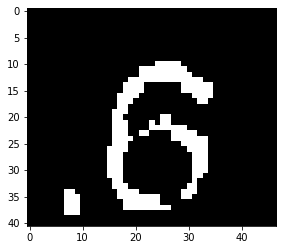

In [11]:
newIm = getProcessedCell(cropped,pre_filled_cells[-1],0.1)
plt.imshow(newIm,cmap="gray")

In [12]:
#Predictions are done here
def predict_array(selected,image,crop_factor):
    "Predict numbers from cell array"
    #Parameters:
    # selected (list(tuple)):cells (pos) array
    # image (numpy.ndarray):sudoku grid image
    
    #Returns:
    # result (tuple):prediction and corresponding cell image
    model = load_model("model.h5")
    data = []
    for cell in selected:
        newIm = getProcessedCell(image,cell,crop_factor)
        resized_im = cv2.resize(newIm, (28, 28),  
               interpolation = cv2.INTER_NEAREST)
        data.append((resized_im).reshape((28,28,1))/255)
    
    data = np.array(data)
    predictions = model.predict(data)
    
    return (predictions, data)
(result, data) = predict_array(pre_filled_cells,cropped,0.05)

In [13]:
len(pre_filled_cells)

26

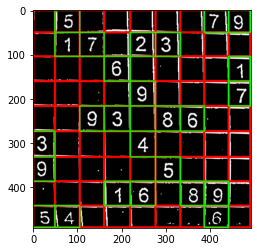

In [14]:
plt.imshow(image)

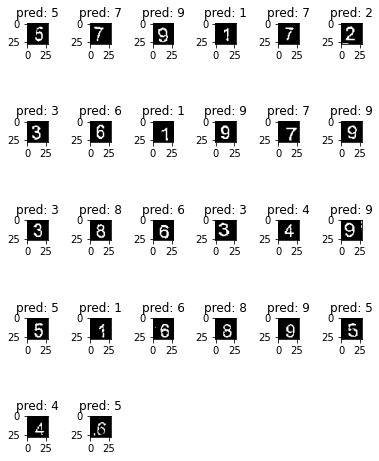

In [15]:
#display predictions here for checking
import matplotlib.pyplot as plt


for i in range(len(pre_filled_cells)):
    plt.subplot(6,6,i+1)
    plt.title("pred: "+str(np.argmax(result[i])+1))
    plt.imshow(data[i].reshape((28,28)),cmap="gray")
    
plt.subplots_adjust(hspace=1, wspace=2,top=2)
plt.show()
    

    

In [16]:
#digitized array is created here
digitized = [
        [0 for _ in range(9)] for _ in range(9)
    ]
for pos, res in zip(cell_pos,result):
    y_cord = pos//9
    x_cord = pos-y_cord*9
    digitized[y_cord][x_cord] = np.argmax(res)+1

In [17]:
#Solution is computed here
def checkValidity(arr, i, j, val):
    "checks if number to be placed is valid in sudoku grid"
    
    #Parameters:
    # arr (list):sudoku grid (digital)
    # i (int):row index
    # j (int):col index
    # val (int): number to be checked
    
    #Returns:
    # result (boolean):True or False
    baseI = (i//3)*3
    baseJ = (j//3)*3
    for _i in range(baseI,baseI+3):
        for _j in range(baseJ,baseJ+3):
            if(arr[_i][_j]==val):
                return False
    for _i in range(9):
        if(arr[_i][j]==val):
            return False
    for _j in range(9):
        if(arr[i][_j]==val):
            return False
    return True

def solve(arr, i,j):
    "Solves sudoku grid in place"
    
    #Parameters:
    # arr (list):sudoku grid array (digital)
    # i (int):row index
    # j (int):col index
    
    #Returns:
    # result (boolean):True if grid solved else false
    
    if(i>8):
        i=0
        j+=1
    if(j==9):
        return True
    if(arr[i][j]!=0):
        res = solve(arr,i+1,j)
        if(res):
            return True
        else:
            return False
    for _i in range(1,10):
        res = checkValidity(arr,i,j,_i)
        res2 = False
        if(res):
            arr[i][j] = _i
            res2 = solve(arr,i+1,j)
            if(res2):
                return True
            arr[i][j] = 0
    return False
cpy = digitized.copy()      
solve(cpy,0,0)
    

False

True

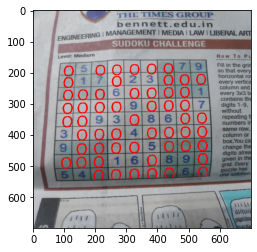

In [18]:
#Overlay to be created here - cpy is the solved array
B_channel = np.zeros(cropped.shape)
G_channel = np.zeros(cropped.shape)
R_channel = np.zeros(cropped.shape)
img_BGRA = cv2.merge((B_channel, G_channel, R_channel))
_i_ = -1
for cell in squares:
    _i_+=1
    if(_i_ in cell_pos):
        continue
    y_cord = _i_//9
    x_cord = _i_-y_cord*9
    img_BGRA = cv2.putText(img_BGRA, str(cpy[y_cord][x_cord]), (cell[0][0]+10,cell[0][1]+55), cv2.FONT_HERSHEY_SIMPLEX ,  
                   2, (255,0,0,1), 3, cv2.LINE_AA) 

    # Performs the transformation on the original image
top_left, top_right, bottom_right, bottom_left = corners[0], corners[1], corners[2], corners[3]
dst = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

side = img_BGRA.shape[0]
src = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
m = cv2.getPerspectiveTransform(src, dst)

new_image_overlay = cv2.warpPerspective(img_BGRA, m, (700,700))
base_img = cv2.resize((img.copy()),(700,700))
fnl_img = np.zeros((700,700,3),dtype="uint8")
for _i_ in range(700):
    for _j_ in range(700):
        if(new_image_overlay[_i_][_j_][0]>150):
            fnl_img[_i_][_j_][0] = new_image_overlay[_i_][_j_][0]
        else:
            fnl_img[_i_][_j_][0] = base_img[_i_][_j_][0]
            fnl_img[_i_][_j_][1] = base_img[_i_][_j_][1]
            fnl_img[_i_][_j_][2] = base_img[_i_][_j_][2]
plt.imshow(fnl_img)
cv2.imwrite("output.jpg",fnl_img)